# Set Up and Getting Data Ready

In [1]:
import os
import s3fs
import math
import weave
import random
import matplotlib.pyplot as plt

from weave.pantry import Pantry
from mpl_toolkits import mplot3d
from weave.mongo_loader import MongoLoader
from weave.index.index_pandas import IndexPandas

In [2]:
# Gets a connection to the mongo db
# This is a weave function (weave.xxx)
client = weave.config.get_mongo_db()

# Provide the mongo client when initializing a pantry object
demo_pantry_path = "mongodb-demo"
demo_pantry = weave.Pantry(
    weave.IndexPandas,
    pantry_path=demo_pantry_path,
    file_system=s3fs.S3FileSystem(client_kwargs = {'endpoint_url': os.environ['S3_ENDPOINT']}),
    mongo_client=client,
)

In [3]:
# Generating some data
# The purpose of metadata is to store a snap shot of the entire dataset. In this trivial example there is the altitude, and speed for
# every second of a 2 hour flight. There is also a singular data point of how much fuel was burned. A big purpose of using pymongo is 
# to store some interesting data points about the data so there is a quick snapshot of the whole dataset. Faster to query singular
# data points such as max_altitude to know more about a particular dataset rather than looking at every altitude data point.
max_altitude = 8_000
for i in range(0,25):
    max_speed = math.floor(900 * random.uniform(1, 2.1))
    fuel_burned = math.floor(max_speed * random.uniform(4.5, 5.2) + random.uniform(-150, 250))
    demo_pantry.upload_basket(
        upload_items=[{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': True}],
        basket_type='ch10',
        metadata = {'ch10name': '652200104150842', 'max_altitude': max_altitude, 'max_speed': max_speed, 'fuel_burned': fuel_burned},
    )
    max_altitude += 350

In [4]:
# Get the pandas df representation of the manifest data of the baskets in the pantry
index = demo_pantry.index
index_df = index.to_pandas_df()
# Getting current weave version for later on in the demo
current_weave_version = index_df.weave_version[0]
# Printing the first 5 baskets
index_df.head()

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,e3103a6e8dbb11f090969e5d1605a090,2025-09-09 20:30:55.646987+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e3103a6e8dbb11f090969e5d1605...,S3FileSystem
1,e327afe68dbb11f090969e5d1605a090,2025-09-09 20:30:55.794505+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e327afe68dbb11f090969e5d1605...,S3FileSystem
2,e3338f1e8dbb11f090969e5d1605a090,2025-09-09 20:30:55.871751+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e3338f1e8dbb11f090969e5d1605...,S3FileSystem
3,e34025448dbb11f090969e5d1605a090,2025-09-09 20:30:55.954158+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e34025448dbb11f090969e5d1605...,S3FileSystem
4,e34eb7128dbb11f090969e5d1605a090,2025-09-09 20:30:56.049190+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e34eb7128dbb11f090969e5d1605...,S3FileSystem


In [5]:
print(f"Index length: {len(index)}")
# value_counts is a pandas function
# https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html
index_df.basket_type.value_counts()

Index length: 50


basket_type
ch10    50
Name: count, dtype: int64

# MongoDB Tutorial

In [6]:
# Initalizing a mongo database for the demo pantry
# Pantry is the pantry object from weave.Pantry()
# If the pantry already has a mongo_client attached to it (if it
# was passed into the pantry constructor, or if it was loaded during
# the factory constructor), the mongo client does not need to be
# passed in explicitly, it will retrieve the pantry's mongo_client.
mongo_loader = MongoLoader(pantry=demo_pantry)
# mongo_client explicitly passed in below
# mongo_loader = MongoLoader(pantry=demo_pantry, mongo_client=client)

This is a function built in house (part of the weave library). Most of the functions built in house for mongo can be found <a href=https://github.com/309thEDDGE/weave/blob/main/weave/mongo_loader.py>here</a>

In [7]:
# Printing the database name to make sure everything is set up properly 
# .database_name is part of weave
print(mongo_loader.database_name)

# Get the pymongo database associated with the pantry
mongo_db = mongo_loader.database
print(mongo_db)

mongodb-demo
Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo')


In [8]:
# This is not an extensive pymongo tutorial just a small introduction
# Printing a list of all the collection names in the mongo database
# list_collection_names() is a pymongo function
collection_names = mongo_db.list_collection_names()
for name in collection_names:
    print(name)

manifest
supplement
metadata


In [9]:
# Getting each collection its own variable
# mongo_loader.xxx_collection is part of weave
manifest_collection = mongo_db[mongo_loader.manifest_collection]
print(manifest_collection)
print(manifest_collection.count_documents({}))

metadata_collection = mongo_db[mongo_loader.metadata_collection]
print(metadata_collection)
print(metadata_collection.count_documents({}))

supplement_collection = mongo_db[mongo_loader.supplement_collection]
print(supplement_collection)
print(supplement_collection.count_documents({}))

Collection(Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo'), 'manifest')
50
Collection(Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo'), 'metadata')
50
Collection(Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo'), 'supplement')
50


In [10]:
# The rest of these functions used in this notebook are standard pymongo functions
# Getting the unique fieldnames (keys) for a collection 
def get_unique_fieldnames(collection):
    fieldnames = set()
    for doc in collection.find():
        def extract_keys(d, prefix=''):
            for k, v in d.items():
                full_key = f"{prefix}.{k}" if prefix else k
                fieldnames.add(full_key)
                if isinstance(v, dict):
                    extract_keys(v, full_key)
                elif isinstance(v, list):
                    for item in v:
                        if isinstance(item, dict):
                            extract_keys(item, full_key)
        extract_keys(doc)
    return fieldnames

# Getting field names for each collection
manifest_fn = get_unique_fieldnames(manifest_collection)
metadata_fn = get_unique_fieldnames(metadata_collection)
supplement_fn = get_unique_fieldnames(supplement_collection)

print("Manifest fieldnames:", manifest_fn, "\n")
print("Metadata fieldnames: ", metadata_fn, "\n")
print("Supplement fieldnames: ", supplement_fn, "\n")

Manifest fieldnames: {'basket_type', '_id', 'label', 'upload_time', 'uuid', 'weave_version', 'parent_uuids'} 

Metadata fieldnames:  {'ch10name', 'basket_type', '_id', 'fuel_burned', 'uuid', 'max_altitude', 'parent_uuids', 'max_speed'} 

Supplement fieldnames:  {'integrity_data.access_date', 'basket_type', '_id', 'upload_items.stub', 'integrity_data.file_size', 'integrity_data.hash', 'integrity_data.byte_count', 'integrity_data.upload_path', 'uuid', 'upload_items', 'integrity_data', 'integrity_data.source_path', 'integrity_data.stub', 'upload_items.path'} 



In [11]:
# Printing out the first 3 items in the metadata collection
print(list(metadata_collection.find({}))[0:3])
print(metadata_collection.count_documents({}))

[{'_id': ObjectId('68c08e7f2616f22bbf877136'), 'uuid': 'e3103a6e8dbb11f090969e5d1605a090', 'basket_type': 'ch10', 'parent_uuids': [], 'ch10name': '652200104150842', 'max_altitude': 8000, 'max_speed': 969, 'fuel_burned': 4447}, {'_id': ObjectId('68c08e7f2616f22bbf87713d'), 'uuid': 'e327afe68dbb11f090969e5d1605a090', 'basket_type': 'ch10', 'parent_uuids': [], 'ch10name': '652200104150842', 'max_altitude': 8350, 'max_speed': 1677, 'fuel_burned': 8346}, {'_id': ObjectId('68c08e7f2616f22bbf877144'), 'uuid': 'e3338f1e8dbb11f090969e5d1605a090', 'basket_type': 'ch10', 'parent_uuids': [], 'ch10name': '652200104150842', 'max_altitude': 8700, 'max_speed': 1396, 'fuel_burned': 6676}]
50


In [12]:
# Printing out the first 3 items in the manifest collection
print(list(manifest_collection.find({}))[0:3])
print(manifest_collection.count_documents({}))

[{'_id': ObjectId('68c08e7f3d06b4cc72c28fbd'), 'uuid': 'e3103a6e8dbb11f090969e5d1605a090', 'upload_time': '2025-09-09T20:30:55.646987+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.15.2'}, {'_id': ObjectId('68c08e7f3d06b4cc72c28fbf'), 'uuid': 'e327afe68dbb11f090969e5d1605a090', 'upload_time': '2025-09-09T20:30:55.794505+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.15.2'}, {'_id': ObjectId('68c08e7f3d06b4cc72c28fc1'), 'uuid': 'e3338f1e8dbb11f090969e5d1605a090', 'upload_time': '2025-09-09T20:30:55.871751+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.15.2'}]
50


In [13]:
# Printing out the first 3 items in the supplement collection
print(list(supplement_collection.find({}))[0:3])
print(supplement_collection.count_documents({}))

[{'_id': ObjectId('68c08e7f3d06b4cc72c28fbe'), 'uuid': 'e3103a6e8dbb11f090969e5d1605a090', 'basket_type': 'ch10', 'integrity_data': [{'file_size': 1024780, 'hash': '29b43ef8fe61d0077138f04b2570f6bc311255aa90ac6caedb07827ec2704c7c', 'access_date': '2025-09-09T20:30:55.646967+00:00', 'source_path': '/home/jovyan/opal/resources/652200104150842.ch10', 'byte_count': 100000000, 'stub': True, 'upload_path': 'stub'}], 'upload_items': [{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': True}]}, {'_id': ObjectId('68c08e7f3d06b4cc72c28fc0'), 'uuid': 'e327afe68dbb11f090969e5d1605a090', 'basket_type': 'ch10', 'integrity_data': [{'file_size': 1024780, 'hash': '29b43ef8fe61d0077138f04b2570f6bc311255aa90ac6caedb07827ec2704c7c', 'access_date': '2025-09-09T20:30:55.794488+00:00', 'source_path': '/home/jovyan/opal/resources/652200104150842.ch10', 'byte_count': 100000000, 'stub': True, 'upload_path': 'stub'}], 'upload_items': [{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 

In [14]:
# Find one item with a basket_type of ch10 in the manifest collection
# This is more efficiently done using weave indexing
ch10_find_one = manifest_collection.find_one({"basket_type": "ch10"})
print(ch10_find_one)

{'_id': ObjectId('68c08e7f3d06b4cc72c28fbd'), 'uuid': 'e3103a6e8dbb11f090969e5d1605a090', 'upload_time': '2025-09-09T20:30:55.646987+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.15.2'}


In [15]:
# Print all of the items that has a weave version of 1.14.2 in the manifest collection
# This is more efficiently done using weave indexing
print(f"Weave version {current_weave_version}")
for doc in manifest_collection.find({"weave_version": current_weave_version}).limit(5):
    print(doc)

# Different weave version not in data
# Nothing was printed because nothing with weave version 589.13.4
print("Weave version 589.13.4")
for doc in manifest_collection.find({"weave_version": "589.13.4"}).limit(5):
    print(doc)

Weave version 1.15.2
{'_id': ObjectId('68c08e7f3d06b4cc72c28fbd'), 'uuid': 'e3103a6e8dbb11f090969e5d1605a090', 'upload_time': '2025-09-09T20:30:55.646987+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.15.2'}
{'_id': ObjectId('68c08e7f3d06b4cc72c28fbf'), 'uuid': 'e327afe68dbb11f090969e5d1605a090', 'upload_time': '2025-09-09T20:30:55.794505+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.15.2'}
{'_id': ObjectId('68c08e7f3d06b4cc72c28fc1'), 'uuid': 'e3338f1e8dbb11f090969e5d1605a090', 'upload_time': '2025-09-09T20:30:55.871751+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.15.2'}
{'_id': ObjectId('68c08e803d06b4cc72c28fc3'), 'uuid': 'e34025448dbb11f090969e5d1605a090', 'upload_time': '2025-09-09T20:30:55.954158+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.15.2'}
{'_id': ObjectId('68c08e803d06b4cc72c28fc5'), 'uuid': 'e34eb7128dbb11f090969e5d1605

In [16]:
# Getting uuid for each item in the manifest collection
all_uuids_find = manifest_collection.find({}, {'uuid': True})
print(all_uuids_find)
print(len(list(all_uuids_find.clone())))

for i in range(0, 5):
    print(all_uuids_find[i]['uuid'])

50
e3103a6e8dbb11f090969e5d1605a090
e327afe68dbb11f090969e5d1605a090
e3338f1e8dbb11f090969e5d1605a090
e34025448dbb11f090969e5d1605a090
e34eb7128dbb11f090969e5d1605a090


In [17]:
# Printing out all the uuids for each item in the manifest collection using the find() function in a different way
for i in range(0, 5):
    object_id = manifest_collection.find()[i]['uuid']
    print(object_id)

# Can be done this way, but do not want to print out all uuids
# for document in manifest_collection.find():
#     object_id = document['uuid']
#     print(object_id)

e3103a6e8dbb11f090969e5d1605a090
e327afe68dbb11f090969e5d1605a090
e3338f1e8dbb11f090969e5d1605a090
e34025448dbb11f090969e5d1605a090
e34eb7128dbb11f090969e5d1605a090


In [18]:
# Another example to get uuids by using the distinct function to get all uuids (trivial example to show some different functions,
# since all uuids are distinct)
manifest_ids = manifest_collection.distinct('uuid')
print(len(manifest_ids))
print(manifest_ids[0:10])

50
['14f9aba48dc211f085af662dec570ff3', '15138c868dc211f085af662dec570ff3', '1529aaf28dc211f085af662dec570ff3', '153bbecc8dc211f085af662dec570ff3', '154d3f9e8dc211f085af662dec570ff3', '155f50268dc211f085af662dec570ff3', '1570fa248dc211f085af662dec570ff3', '158219588dc211f085af662dec570ff3', '159398228dc211f085af662dec570ff3', '15a47d5e8dc211f085af662dec570ff3']


# Less trival examples

In [19]:
# Getting all documents' uuid's in metadata_collection that follows the query below
# max_altitude > 10_000
# max_speed < 1_450
# fuel_burned >= 6_000 and <= 8_000
query = {"max_altitude": {"$gt": 10_000}, "max_speed": {"$lt": 1_450}, "fuel_burned": {"$gte": 6_000, "$lte": 8_000}}

# Querying data like this is the main purpose of using a mongo db
# Upload baskets with metadata to a pantry, and query the metadata using mongo.
doc_uuids = list(metadata_collection.find(query))

print(f"There are {len(doc_uuids)} out of {metadata_collection.count_documents({})} documents that satisfy the above query")
print(f"Those documents' uuid's are \n{doc_uuids}")

There are 7 out of 50 documents that satisfy the above query
Those documents' uuid's are 
[{'_id': ObjectId('68c08e802616f22bbf87717c'), 'uuid': 'e3a93ef88dbb11f090969e5d1605a090', 'basket_type': 'ch10', 'parent_uuids': [], 'ch10name': '652200104150842', 'max_altitude': 11500, 'max_speed': 1339, 'fuel_burned': 7122}, {'_id': ObjectId('68c08e812616f22bbf877191'), 'uuid': 'e3d80c608dbb11f090969e5d1605a090', 'basket_type': 'ch10', 'parent_uuids': [], 'ch10name': '652200104150842', 'max_altitude': 12550, 'max_speed': 1368, 'fuel_burned': 6742}, {'_id': ObjectId('68c08e812616f22bbf8771bb'), 'uuid': 'e437dfaa8dbb11f090969e5d1605a090', 'basket_type': 'ch10', 'parent_uuids': [], 'ch10name': '652200104150842', 'max_altitude': 14650, 'max_speed': 1348, 'fuel_burned': 6690}, {'_id': ObjectId('68c08e822616f22bbf8771d0'), 'uuid': 'e46ac5968dbb11f090969e5d1605a090', 'basket_type': 'ch10', 'parent_uuids': [], 'ch10name': '652200104150842', 'max_altitude': 15700, 'max_speed': 1211, 'fuel_burned': 6129

More on how to query collections can be found
<a href="https://www.w3schools.com/python/python_mongodb_query.asp">here</a>.

In [20]:
# 25 documents have metadata (metadata was entered when it was uploaded to the basket)
# 2 documents do not have metadata
print(metadata_collection.count_documents({}))

50


In [21]:
# Adding more data
# Automatically gets uploaded to the mongo_db with basket_type ch10_2 (ch10 for the previous time data was uploaded)
max_altitude = 8_000
for i in range(0,25):
    max_speed = math.floor(900 * random.uniform(1, 2.1))
    fuel_burned = math.floor(max_speed * random.uniform(4.5, 5.2) + random.uniform(-150, 250))
    demo_pantry.upload_basket(
        upload_items=[{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': True}],
        basket_type='ch10_2',
        metadata = {'ch10name': '652200104150842', 'max_altitude': max_altitude, 'max_speed': max_speed, 'fuel_burned': fuel_burned},
    )
    max_altitude += 350

In [22]:
# Pandas df representation
index = demo_pantry.index
index_df = index.to_pandas_df()
index_df.head()

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,e3103a6e8dbb11f090969e5d1605a090,2025-09-09 20:30:55.646987+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e3103a6e8dbb11f090969e5d1605...,S3FileSystem
1,e327afe68dbb11f090969e5d1605a090,2025-09-09 20:30:55.794505+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e327afe68dbb11f090969e5d1605...,S3FileSystem
2,e3338f1e8dbb11f090969e5d1605a090,2025-09-09 20:30:55.871751+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e3338f1e8dbb11f090969e5d1605...,S3FileSystem
3,e34025448dbb11f090969e5d1605a090,2025-09-09 20:30:55.954158+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e34025448dbb11f090969e5d1605...,S3FileSystem
4,e34eb7128dbb11f090969e5d1605a090,2025-09-09 20:30:56.049190+00:00,[],ch10,,1.15.2,mongodb-demo/ch10/e34eb7128dbb11f090969e5d1605...,S3FileSystem


In [23]:
# The 25 items are in minio as ch10_2 basket type
print(f"Index length: {len(index)}")
index_df.basket_type.value_counts()

Index length: 75


basket_type
ch10      50
ch10_2    25
Name: count, dtype: int64

In [24]:
# Those 25 items uploaded to minio are also in the mongo_db
# There are 50 documents that have a metadata collection
metadata_collection = mongo_db[mongo_loader.metadata_collection]
print(metadata_collection.count_documents({}))

75


In [25]:
# Lets see how many documents satisfy the same query
# Include uuid column exclude _id column (_id column gets automatically put into the list)
projection = {"uuid": 1, "_id": 0}
doc_uuids = list(metadata_collection.find(query, projection))

print(f"There are {len(doc_uuids)} out of {metadata_collection.count_documents({})} documents that satisfy the above query")
print(f"Those documents' uuid's are \n{doc_uuids}")

There are 10 out of 75 documents that satisfy the above query
Those documents' uuid's are 
[{'uuid': 'e3a93ef88dbb11f090969e5d1605a090'}, {'uuid': 'e3d80c608dbb11f090969e5d1605a090'}, {'uuid': 'e437dfaa8dbb11f090969e5d1605a090'}, {'uuid': 'e46ac5968dbb11f090969e5d1605a090'}, {'uuid': 'e47cc1108dbb11f090969e5d1605a090'}, {'uuid': '158219588dc211f085af662dec570ff3'}, {'uuid': '1626d4988dc211f085af662dec570ff3'}, {'uuid': '17cbfe9a8dc211f085af662dec570ff3'}, {'uuid': '18262e608dc211f085af662dec570ff3'}, {'uuid': '18d688788dc211f085af662dec570ff3'}]


# Graph the Data

In [26]:
labels = []
max_speed_data = []
fuel_burned_data = []
max_altitude_data = []
# Making the list of dictionaries just of list of uuids
doc_uuids = [d['uuid'] for d in doc_uuids]

# Get data for the graph
for doc in metadata_collection.find():
    # If it satisfied the query from above then add True to label
    # This is so we can have those labels be a different color from the rest
    if doc['uuid'] in doc_uuids:
        labels.append(True)
    else:
        labels.append(False)
    max_speed_data.append(doc['max_speed'])
    fuel_burned_data.append(doc['fuel_burned'])
    max_altitude_data.append(doc['max_altitude'])

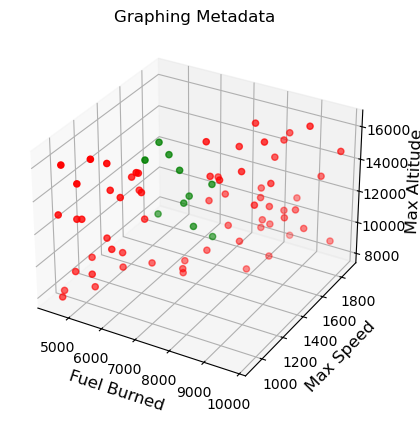

In [27]:
# Create 3d axes
fig = plt.figure()
ax = plt.axes(projection='3d')
 
# Data
x = fuel_burned_data
y = max_speed_data
z = max_altitude_data
colors = ['green' if label == True else 'red' for label in labels]
ax.scatter(x, y, z, c=colors)

ax.set_title('Graphing Metadata', fontsize=12)
ax.set_xlabel('Fuel Burned', fontsize=12)
ax.set_ylabel('Max Speed', fontsize=12)
ax.set_zlabel('Max Altitude', fontsize=12)
 
plt.show()

# Inserting More Data

In [28]:
# Uploading baskets to the demo_pantry while not giving weave.Pantry a mongo_client
demo_pantry = weave.Pantry(
    weave.IndexPandas,
    pantry_path=demo_pantry_path,
    file_system=s3fs.S3FileSystem(client_kwargs = {'endpoint_url': os.environ['S3_ENDPOINT']}),
)

demo_index = demo_pantry.index

for i in range(0,5):
    demo_pantry.upload_basket(
        upload_items=[{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': True}],
        basket_type='ex1',
        metadata = {'max_altitude': 8_000, 'max_speed': 1_250, 'fuel_burned': 5_000},
    )

In [29]:
# Pandas df representation
# New items are recognized by the index and are at the bottom of the dataframe if displaying index_df
index = demo_pantry.index
index_df = demo_pantry.index.to_pandas_df()
len(index_df)

80

In [30]:
# Will be at 50 since the new data was not uploaded to the mongo database because weave.Pantry was not given a mongo_client
metadata_collection = mongo_db[mongo_loader.metadata_collection]
print(metadata_collection.count_documents({}))

75


In [31]:
# The ex1 basket is in minio but not in mongo database because length is 55
print(f"Index length: {len(index)}")
index_df.basket_type.value_counts()

Index length: 80


basket_type
ch10      50
ch10_2    25
ex1        5
Name: count, dtype: int64

In [32]:
# Getting the uuids from the newly created baskets
# The newly created baskets are all of basket type 'ex1'
# This line of code is just pandas df code (no weave or opal specific fucntions)
ex1_uuids = list((index_df.loc[index_df['basket_type']=='ex1', 'uuid']))
print(ex1_uuids)
print(len(ex1_uuids))

['194e23748dc211f085af662dec570ff3', '19cc1e328dc211f085af662dec570ff3', '19d81f488dc211f085af662dec570ff3', '19e40d8a8dc211f085af662dec570ff3', '19f069228dc211f085af662dec570ff3']
5


In [33]:
# Uploading items to the mongo database manually (items' uuid to upload to mongo is required)
mongo_loader.load_mongo(ex1_uuids)

In [34]:
# Will be 55 since the documents were uploaded to the mongo database
metadata_collection = mongo_db[mongo_loader.metadata_collection]
print(metadata_collection.count_documents({}))

80


# Cleanup

In [35]:
# Deleting the pantry
s3 = s3fs.S3FileSystem(client_kwargs = {'endpoint_url': os.environ['S3_ENDPOINT']})
if s3.exists(demo_pantry_path):
    s3.rm(f's3://{demo_pantry_path}', recursive = True)
s3.mkdir(demo_pantry_path)

In [36]:
# Clearing mongo database
mongo_loader.clear_mongo()